# Regression Splines Notebook
- Build B-spline design for selected features with df grid
- Cross-validate df choice, fit OLS, evaluate on test

In [3]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import patsy

In [9]:
# local utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from utils_plots import plot_pred_vs_actual, plot_residuals, report_mse

# load train/test data
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_path = os.path.join(DATA_DIR, 'concrete_train.csv')
test_path  = os.path.join(DATA_DIR, 'concrete_test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

predictors = [c for c in train_df.columns if c != 'concrete_compressive_strength']

In [38]:
# Treat all predictors with splines
dfs = [3, 4, 5, 6]
degrees = [1, 2, 3]

def design_matrix(df, df_spline, deg):
    terms = []
    for f in spline_feats:
        terms.append(f"bs({f}, df={df_spline}, degree={deg})")
    formula = " + ".join(terms)
    X = patsy.dmatrix(formula, df, return_type='dataframe')
    return X

# CV over deg and df
cv = KFold(n_splits=5, shuffle=True, random_state=598)
cv_results = {}
for deg in degrees:
    for df_spline in dfs:
        mse_list = []
        for tr_idx, va_idx in cv.split(train_df):
            tr = train_df.iloc[tr_idx]
            va = train_df.iloc[va_idx]

            X_tr = design_matrix(tr, df_spline, deg)
            y_tr = tr["concrete_compressive_strength"].values
            X_va = design_matrix(va, df_spline, deg)
            y_va = va["concrete_compressive_strength"].values

            model = sm.OLS(y_tr, X_tr).fit()
            pred_va = model.predict(X_va)
            mse_list.append(mean_squared_error(y_va, pred_va))

        mean_mse = np.mean(mse_list)
        cv_results[(df_spline, deg)] = mean_mse
        print(f"df={df_spline:>2}, degree={deg}: CV MSE={mean_mse:.4f}")

df= 3, degree=1: CV MSE=56.0262
df= 4, degree=1: CV MSE=63.0974
df= 5, degree=1: CV MSE=50.2784
df= 6, degree=1: CV MSE=51.4053
df= 3, degree=2: CV MSE=51.2941
df= 4, degree=2: CV MSE=57.1283
df= 5, degree=2: CV MSE=55.3926
df= 6, degree=2: CV MSE=48.6837
df= 3, degree=3: CV MSE=60.1282
df= 4, degree=3: CV MSE=52.0051
df= 5, degree=3: CV MSE=55.7538
df= 6, degree=3: CV MSE=51.2135


In [48]:
# Sort and display results
cv_sorted = sorted(cv_results.items(), key=lambda x: x[1])
best_params, best_mse = cv_sorted[0]
best_df, best_degree = best_params

print(f"\nBest params: df={best_df}, degree={best_degree}, CV MSE={round(best_mse,2)}")


Best params: df=6, degree=2, CV MSE=48.68


Test MSE: 49.4533358778557


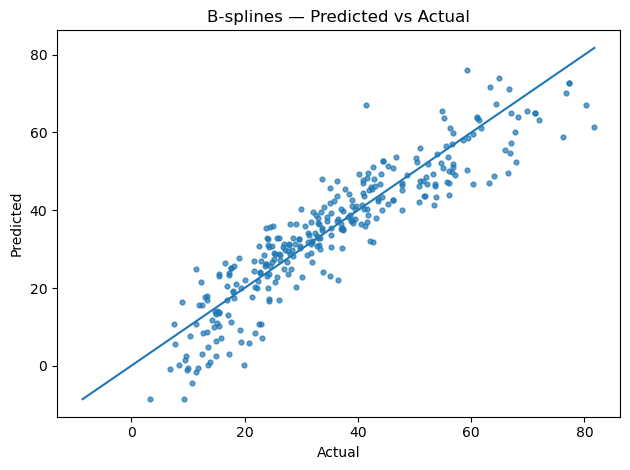

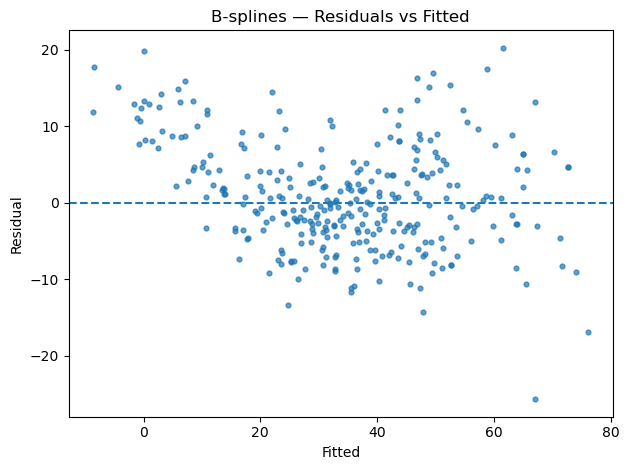

In [50]:
# Fit on full training set and evaluate on test
X_train = design_matrix(train_df, best_df, best_degree)
y_train = train_df['concrete_compressive_strength'].values
X_test = design_matrix(test_df, best_df, best_degree)
y_test = test_df['concrete_compressive_strength'].values

model = sm.OLS(y_train, X_train).fit()
y_pred_test = model.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred_test)
print("Test MSE:", test_mse)

fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'reports', 'figures')
plot_pred_vs_actual(y_test, y_pred_test, title='B-splines — Predicted vs Actual', save_path=os.path.join(fig_dir, 'bs_pv.png'))
plot_residuals(y_test, y_pred_test, title='B-splines — Residuals vs Fitted', save_path=os.path.join(fig_dir, 'bs_resid.png'))